<a href="https://colab.research.google.com/github/y33-j3T/TensorFlow/blob/master/Classifying_Images_of_Clothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Images of Clothing

## Install and import dependencies

Install [TensorFlow Datasets](https://www.tensorflow.org/datasets/) - API that simplifies downloading and accessing datasets

In [37]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [38]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)
tf.enable_eager_execution()

1.13.1


## Import Fashion MNIST dataset

 ### Overview of [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset
 - 70, 000 grayscale images
 - 10 categories
 - Individual articles of clothing at low resolution (28 $\times$ 28 pixels)
 
 <table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="600">
    <td></tr>
  </table>
  
   <p align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist"> Fashion-MNIST samples</a>
  </p>
  

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

<p align="center">
  <b>Table 1.</b>
  <a> 10 categorical classes </a>
</p>

In [0]:
#Store `class_names` for later use
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Load data
- Dataset - `dataset`
- Metadata - `metadata`
- Train set - `train_dataset`
- Test set - `test_dataset`

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

### Explore the data

In [41]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of train examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of train examples: 60000
Number of test examples: 10000


## Preprocess the data

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the processed data

Display a single image

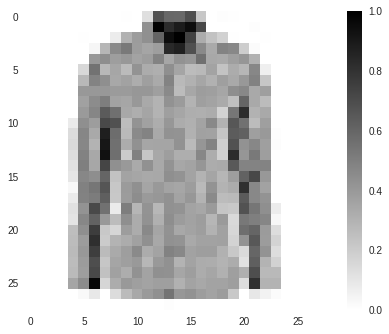

In [43]:
# Take a single image, remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

1. Display first 25 image from the *training set*
2. Display class name below each image
3. Verify data in correct format

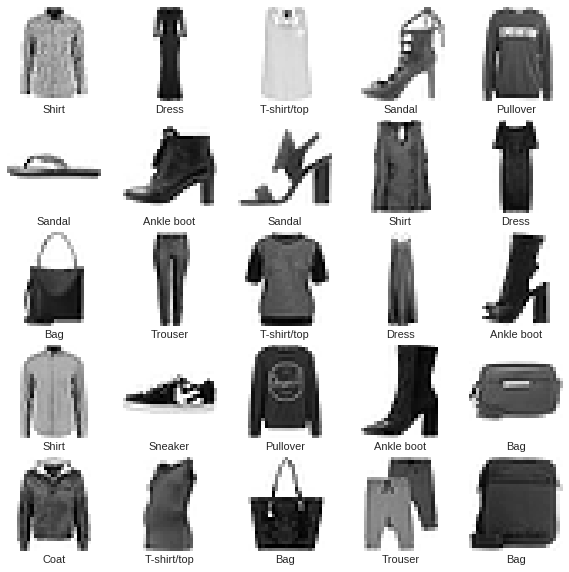

In [44]:
plt.figure(figsize=(10,10))
i=0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

## Build the model
1. Configure layers of model
2. Compile the model

### Setup the layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

This network has 3 layers:
- **input layer** `tf.keras.layers.Flatten` -- Transforms images of *2d-array* 28 $\times$ 28 pixels to *1d-array* of 784 pixels. This layer has **no parameters** to learn, only **reformats data**.

- **hidden layer** `tf.keras.layers.Dense -- A densely connected layer of **128 neurons**. Each neuron(or node) takes **input from all 784 nodes** in the previous layer, weighting that input according to hidden parameters which will be learned during training, and **outputs a single value** to the next layer.

- **output layer** `tf.keras.layers.Dense` -- A **10 node** *softmax* layer, with each node representing a class of clothing. Each node takes **input from all 128 nodes** in the previous layer, weights the input according to learned parameters, then **outputs a value in the range [0, 1]**, representing the probability that the image belongs to that class.

### Compile the model
- Loss function -- An algorithm for measuring how far the model's outputs are from the desired output.

- Optimizer -- An algorithm for adjusting the inner parameters of the model to minimize loss.

- Metrics -- Used to monitor training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

Define iteration behavior for `train_dataset`:
1.  Repeat forever by specifying `train_dataset.repeat()` (the `epochs` parameter limits how long we perform training)

2. `train_dataset.shuffle(60000)` randomizes the order so model cannot learn anything from the order of examples.

3. `train_dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating model variables.

Training performed by calling `model.fit`:
1. Feed the training data to the model using `train_dataset`.
2. Model learns to associate images and labels.
3. `epochs=5` limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [48]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.4929 - acc: 0.8261
Epoch 2/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3711 - acc: 0.8661
Epoch 3/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3373 - acc: 0.8769
Epoch 4/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3036 - acc: 0.8877
Epoch 5/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2926 - acc: 0.8921


## Evaluate accuracy

In [49]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print("Accuracy on test dataset: ", test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3534 - acc: 0.8729
Accuracy on test dataset:  0.8729


## Make predictions and explore

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [51]:
predictions.shape

(32, 10)

The model has predicted the label for each image in the testing set. 

In [52]:
# First prediction
predictions[0]

array([6.4593150e-05, 3.7474848e-07, 9.8140482e-03, 5.9929258e-05,
       5.8053423e-02, 1.0318063e-07, 9.3200254e-01, 8.7957863e-10,
       4.9007590e-06, 1.2805168e-09], dtype=float32)

A prediction is an array of 10 numbers. They describe the "confidence" of the model that the image corresponds to the different 10 categories of clothing. 

In [53]:
# Label with higest confidence value
np.argmax(predictions[0])

6

So the model is most confident that this image is a shirt, or `class_names[6]`. Let's check the test label to see if this is correct.

In [54]:
test_labels[0]

6

We can graph this to look at the full set of 10 channels

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(img[...,0], cmap=plt.cm.binary) 
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 
                                       100*np.max(predictions_array), 
                                       class_names[true_label]), 
             color=color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at 0th image, predictions, and prediction array.

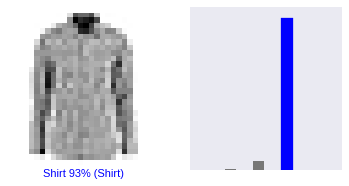

In [56]:
i = 0
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)

plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions.

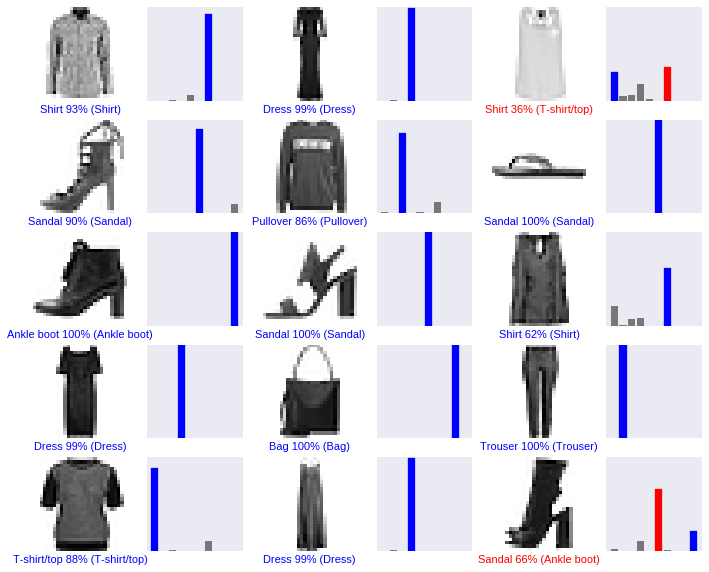

In [57]:
# Plot the first X test images, their predicted label, and the true label
# Color the correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Use the model to make a prediction about a single image.

In [58]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

(28, 28, 1)


  `tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once.
  So even though we're using a single image, we need to add it to a list:

In [59]:
# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


Now predict the image:

In [61]:
predictions_single = model.predict(img)
print(predictions_single)

[[6.4593034e-05 3.7474851e-07 9.8140491e-03 5.9929378e-05 5.8053371e-02
  1.0318024e-07 9.3200260e-01 8.7957869e-10 4.9007594e-06 1.2805168e-09]]


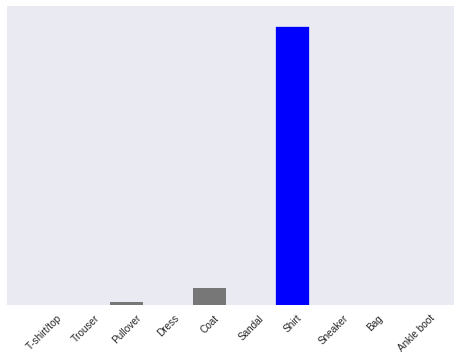

In [62]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. 
Grab the predictions for our (only) image in the batch:

In [64]:
np.argmax(predictions_single[0])

6

And, as before, the model predicts a label of 6 (shirt).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10,  activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes